# Example notebook 1

This exampple illustrates the usage of xarray-based data structures for calculating the Beer-Lambert transformation.

In [5]:
import cedalion
import cedalion.nirs
import cedalion.xrutils
import cedalion.xrutils as xrutils
from cedalion.datasets import get_fingertapping_snirf_path
import numpy as np
import xarray as xr
import pint
import matplotlib.pyplot as p
import scipy.signal
import os.path
xr.set_options(display_max_rows=3, display_values_threshold=50)
np.set_printoptions(precision=4)

### Loading raw CW-NIRS data from a SNIRF file
This notebook uses a finger-tapping dataset in BIDS layout provided by [Rob Luke](https://github.com/rob-luke/BIDS-NIRS-Tapping). It can can be downloaded via `cedalion.datasets`.

Load amplitude data from the snirf file.

In [6]:
# path_to_snirf_file = get_fingertapping_snirf_path()
path_to_snirf_file = '../src/cedalion/2024-04-09_001.snirf'

elements = cedalion.io.read_snirf(path_to_snirf_file)
element = elements[0] # there is only one NirsElement in this snirf file...
amp = element.data[0] # ... which holds amplitude data

# restrict to first 60 seconds and fill in missing units
amp = amp.sel(time=amp.time < 60)
amp = amp.pint.dequantify().pint.quantify("V")
geo3d = element.geo3d


ExGa1 has shape (457951,)


C:\Users\isawa\anaconda3\envs\cedalion\lib\site-packages\xarray\core\variable.py:306: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.asarray(data)


--------[ 0.0034  0.0034  0.0034 ... -0.0008 -0.0008 -0.0008]
----------------------------------------------------------------------
ExGa2 has shape (457951,)
--------[-0.0043 -0.0117 -0.0145 ... -0.0087 -0.0107 -0.0079]
----------------------------------------------------------------------
ExGa3 has shape (457951,)
--------[-0.0174 -0.0312 -0.0371 ... -0.0244 -0.0297 -0.0267]
----------------------------------------------------------------------
ExGa4 has shape (457951,)
--------[-0.0175 -0.03   -0.0359 ... -0.0261 -0.029  -0.0256]
----------------------------------------------------------------------
ECG has shape (457951,)
--------[-0.007   0.049   0.0635 ... -0.0068  0.0488  0.0623]
----------------------------------------------------------------------
Respiration has shape (457951,)
Respiration got an error: Cannot parse units:
    invalid units for variable 'Respiration': Ohm (attribute) (reason: 'Ohm' is not defined in the unit registry)
-----------------------------------------

In [7]:
elements

### Amplitude data

In [8]:
display(amp.round(4))

Magnitude,[[[0.4499 0.4495 0.4463 ... 0.4038 0.4029 0.4059] [0.7243 0.7226 0.7156 ... 0.6388 0.6375 0.6421]] [[0.0795 0.0794 0.0792 ... 0.0872 0.087 0.0867] [0.2001 0.2 0.1994 ... 0.2274 0.2263 0.2252]] [[0.0486 0.0475 0.0468 ... 0.0427 0.0426 0.043] [0.0574 0.0559 0.0548 ... 0.0481 0.0481 0.0484]] ... [[0.3249 0.323 0.3216 ... 0.3109 0.3104 0.3098] [0.5324 0.527 0.5238 ... 0.4944 0.4934 0.4927]] [[0.4837 0.4776 0.4744 ... 0.4438 0.4446 0.4451] [0.6323 0.6204 0.6138 ... 0.5435 0.5454 0.5469]] [[0.0696 0.0688 0.0683 ... 0.0629 0.063 0.0635] [0.1195 0.1175 0.1164 ... 0.1042 0.1045 0.1051]]]
Units,volt


### Montage information

The `geo3d` DataArray maps labels to 3D positions, thus storing the location of optodes and landmarks.

In [9]:
display_labels = ["S1", "S2", "D1", "D2"] # for brevity show only these
geo3d.round(5).sel(label=display_labels)

Magnitude,[[-51.83 55.753 37.164] [-54.498 68.788 -18.293] [-64.987 49.59 10.244] [-29.48 60.438 57.351]]
Units,millimeter


To obtain channel distances, we can lookup `amp`'s source and detector coordinates in `geo3d`,
subtract these and calculate the vector norm.

In [10]:
dists = xrutils.norm(geo3d.loc[amp.source] - geo3d.loc[amp.detector], dim="pos")
display(dists.round(3))

Magnitude,[30.59 30.479 35.958 30.399 45.582 31.593 39.104 30.428 39.795 30.22 30.365 39.942 29.893 38.727 45.375 31.428 30.273 30.38 29.826 35.546]
Units,millimeter


### Beer-Lambert transformation

Specify differential path length factors (DPF). Obtain a matrix of tabulated extinction coefficients for the wavelengths of our dataset and calculate the inverse.

In [11]:
dpf = xr.DataArray([6., 6.], dims="wavelength", coords={"wavelength" : [760., 850.]})

E = cedalion.nirs.get_extinction_coefficients("prahl", amp.wavelength)
Einv = cedalion.xrutils.pinv(E)
display(Einv.round(4))

Magnitude,[[-0.0024 0.0037] [0.0055 -0.0021]]
Units,millimeter molar


In [12]:
optical_density =  -np.log( amp / amp.mean("time"))

conc = Einv @ (optical_density / ( dists * dpf))

display(conc.pint.to("micromolar").round(4))

Magnitude,[[[1.1652 1.2206 1.4158 ... 3.4627 3.4938 3.3788] [0.6684 0.6786 0.725 ... -1.9131 -1.8039 -1.6979] [-0.7478 -0.355 -0.0183 ... 2.2469 2.259 2.1661] ... [0.965 1.1904 1.3157 ... 2.5899 2.6278 2.649] [1.1275 1.5381 1.7726 ... 4.5692 4.4888 4.4225] [0.5308 0.8494 0.9946 ... 2.8988 2.8357 2.7636]] [[0.3783 0.3702 0.4051 ... 1.159 1.182 1.1135] [-0.0408 -0.0355 -0.011 ... -0.4902 -0.4908 -0.4735] [-0.2578 -0.1046 -0.0499 ... 0.2801 0.3065 0.227] ... [0.0063 0.0128 0.0309 ... 0.0661 0.0799 0.1004] [0.2507 0.293 0.3107 ... 0.2962 0.2969 0.3044] [-0.2383 -0.2126 -0.1698 ... 0.1905 0.1918 0.1235]]]
Units,micromolar


20.345052083333332


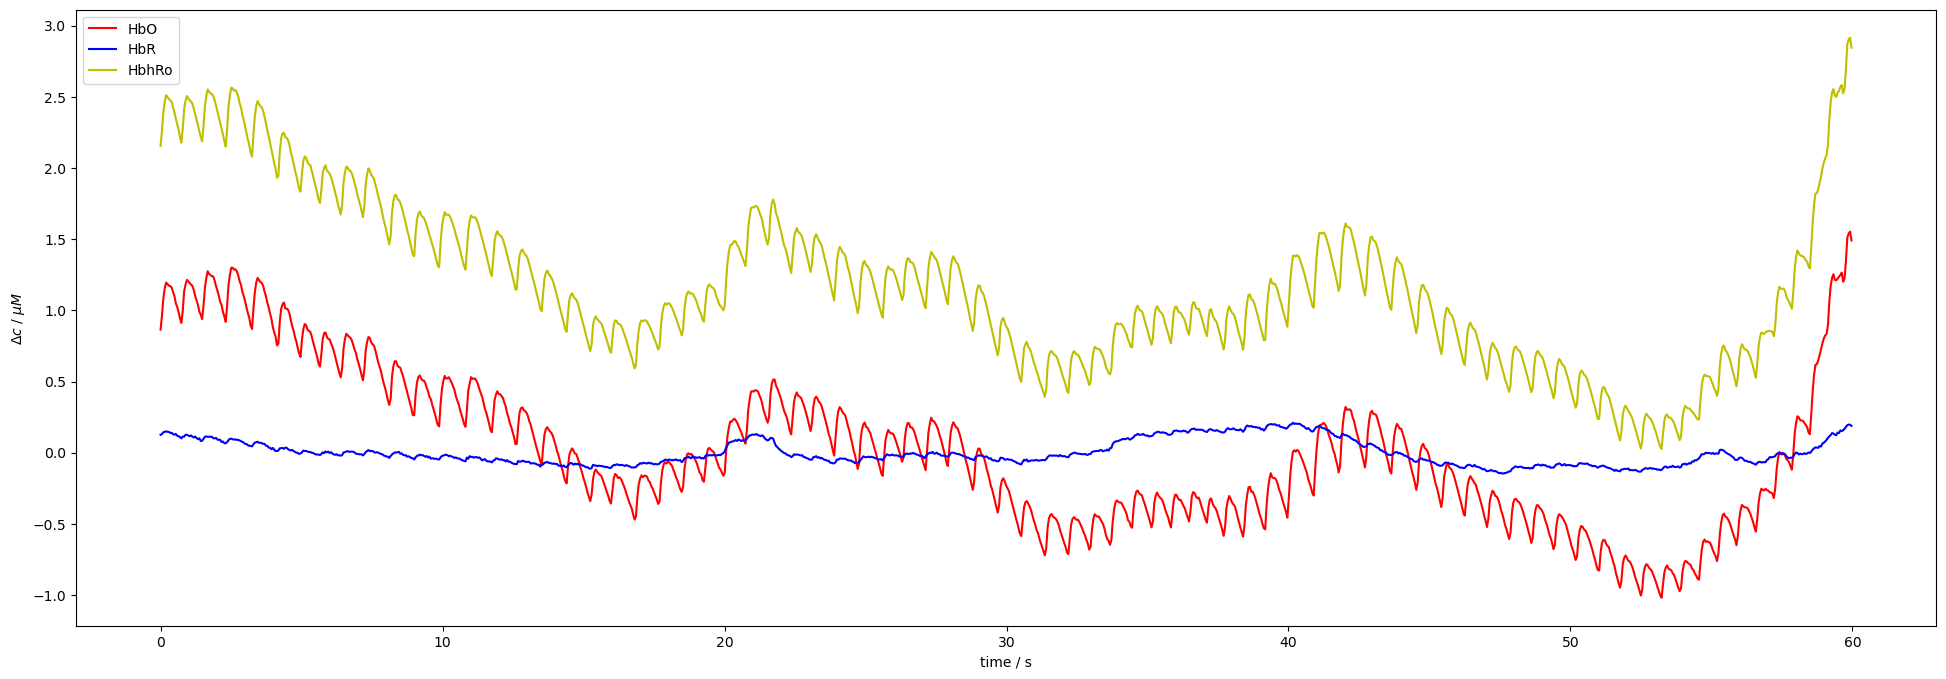

In [13]:
f,ax = p.subplots(1,1, figsize=(24,8))
s = 'S3D4'
# ax.plot( conc.time, conc.sel(channel="S3D4", chromo="HbO").pint.to("micromolar"), "r-", label="HbO")
# ax.plot( conc.time, conc.sel(channel="S3D4", chromo="HbR").pint.to("micromolar"), "b-", label="HbR")
# ax.plot( conc.time, conc.sel(channel="S6D4", chromo="HbO").pint.to("micromolar"), "r-", label="HbO")
# ax.plot( conc.time, conc.sel(channel="S6D4", chromo="HbR").pint.to("micromolar"), "b-", label="HbR")
# ax.plot( conc.time, conc.sel(channel="S1D1", chromo="HbO").pint.to("micromolar"), "r-", label="HbO")
# ax.plot( conc.time, conc.sel(channel="S1D1", chromo="HbR").pint.to("micromolar"), "b-", label="HbR")
ax.plot( conc.time, conc.sel(channel=s, chromo="HbO").pint.to("micromolar"), "r-", label="HbO")
ax.plot( conc.time, conc.sel(channel=s, chromo="HbR").pint.to("micromolar"), "b-", label="HbR")
hbo = conc.sel(channel=s, chromo="HbO")
hbr = conc.sel(channel=s, chromo="HbR")
hbhro = hbo + hbr - hbo.min() - hbr.min()
ax.plot( conc.time, hbhro.pint.to("micromolar"), "y-", label="HbhRo")
p.legend()
ax.set_xlabel("time / s")
ax.set_ylabel("$\Delta c$ / $\mu M$")
print(f'{conc.cd.sampling_rate}')